In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [87]:
import nltk 
import random 
from nltk.tokenize import word_tokenize
nltk.download('punkt') 
nltk.download('stopwords') 
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [89]:
#Importing dataset
url = "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
dataset =  pd.read_csv(url,sep='\t')
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,56062,2804,is debatable .,2
1,46540,2264,female angst,2
2,38969,1859,would be a toss-up between presiding over the ...,0
3,12833,552,it 's based upon,2
4,14301,616,its impacts,2


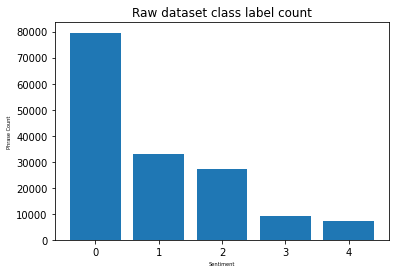

In [90]:
# Check class imbalance in tokenized sentences
count = dataset['Sentiment'].value_counts()

index = np.arange(5)
plt.bar(index, count)
plt.xlabel('Sentiment', fontsize=5)
plt.ylabel('Phrase Count', fontsize=5)
plt.title('Raw dataset class label count')
plt.show()

In [0]:
# Fetching full sentences to remove the class imbalance
fullSentences = []
curSentence = 0
for i in range(dataset.shape[0]):
  if dataset["SentenceId"][i]> curSentence:
    fullSentences.append((dataset['Phrase'][i], dataset['Sentiment'][i]))
    curSentence = curSentence +1

In [92]:
# Dataframe to be used for further preprocessing
fullSentDf = pd.DataFrame(fullSentences,
                                columns=['Phrase', 'Sentiment'])
fullSentDf.head()

,Phrase,Sentiment
0,is debatable .,2
1,female angst,2
2,would be a toss-up between presiding over the ...,0
3,it 's based upon,2
4,its impacts,2


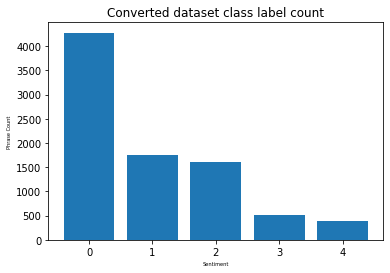

In [93]:
count = fullSentDf['Sentiment'].value_counts()

index = np.arange(5)
plt.bar(index, count)
plt.xlabel('Sentiment', fontsize=5)
plt.ylabel('Phrase Count', fontsize=5)
plt.title('Converted dataset class label count')
plt.show()

In [94]:
#Splitting the dataset into ratio of 70:30
x_train, x_test, y_train, y_test = train_test_split(dataset['Phrase'], dataset['Sentiment'], test_size=0.3, random_state=2003)

# Creating documents by tokenizing the dataset converted into full sentences
documents=[]
x_train = np.array(x_train.values.tolist())
y_train = np.array(y_train.values.tolist())
for i in range(len(x_train)):
  documents.append([list(word_tokenize(x_train[i])), y_train[i]]) 

x_test = np.array(x_test.values.tolist())
y_test = np.array(y_test.values.tolist())
for i in range(len(x_test)):
  documents.append([list(word_tokenize(x_test[i])), y_test[i]]) 

documents[0]

[['the', 'Kafkaesque'], 2]

In [0]:
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer 
porter = PorterStemmer() 
lancaster=LancasterStemmer() 
wordnet_lemmatizer = WordNetLemmatizer() 
stopwords_en = stopwords.words("english") 
punctuations="?:!.,;'\"-()"
remove_stopwords = True
useStemming = False
useLemma = False
removePuncs = True

In [0]:
# Preprocessing of the tokenized dataset by removing punctuations, stopwords
# Lemmatizing and stemming of the tokenized

for l in range(len(documents)):                   
  label = documents[l][1]                         
  tmpReview = []                                  
  for w in documents[l][0]:                        
    newWord = w                                   
    if remove_stopwords and (w in stopwords_en):  
      continue                                    
    if removePuncs and (w in punctuations):        
      continue                                     
    if useStemming: 
      newWord = lancaster.stem(newWord)  
    if useLemma: 
      newWord = wordnet_lemmatizer.lemmatize(newWord) 
    tmpReview.append(newWord)                     
  documents[l] = (tmpReview, label)             
  documents[l] = (' '.join(tmpReview), label)

In [0]:
# Creating a dataframe based on just review and it's corresponding sentiment
dataset = pd.DataFrame(documents, columns=['text', 'sentiment']) 
dataset.head()

x_train, x_test, y_train, y_test = train_test_split(dataset['text'],  dataset['sentiment'], test_size=0.3, random_state=2003)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from keras.utils import to_categorical

#TF-IDF vectorization of the dataset
vector = TfidfVectorizer(max_features = 2000)
X = vector.fit_transform(dataset["text"]) 
Y = dataset['sentiment'] 
 
# Transforming the vectorize dataset into array for further processing 
x_train = vector.transform(x_train).toarray()
x_test = vector.transform(x_test).toarray()

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Embedding
from keras import backend as K

In [0]:
# Converting the sentiment column from numerical to categorical variable

classLabels = 5
y_train = keras.utils.to_categorical(y_train, classLabels)
y_test = keras.utils.to_categorical(y_test, classLabels)

In [0]:
# Model generation for sentiment analysis
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3,
                 activation='relu',
                 input_shape=(2000,1)))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
#To reduce overfitting
model.add(Dropout(rate = 0.50))
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(rate = 0.50))
#Softmax for multi level classification
model.add(Dense(classLabels, activation='softmax'))

In [0]:
#Function to calculate the recall generated after model evaluation

def getRecall(actual, predict):
    truePositive = K.sum(K.round(K.clip(actual * predict, 0, 1)))
    falseNegative = K.sum(K.round(K.clip(actual, 0, 1)))
    recall = truePositive / (falseNegative + K.epsilon())
    return recall

#Function to calculate the precision generated after model evaluation
def getPrecision(actual, predict):
    truePositive = K.sum(K.round(K.clip(actual * predict, 0, 1)))
    falsePositive = K.sum(K.round(K.clip(predict, 0, 1)))
    precision = truePositive / (falsePositive + K.epsilon())
    return precision

#Function to calculate the F1 score generated after model evaluation
def getf1Score(actual, predict):
    precision = getPrecision(actual, predict)
    recall = getRecall(actual, predict)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




In [103]:
# Comipling model using loss function as categorical cross entropy
# Using Adam optimizer for compilation
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',getf1Score,getPrecision, getRecall])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 1998, 64)          256       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1994, 128)         41088     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1994, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1994, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 255232)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16334912  
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)               

In [0]:
# Reshaping of the input to be suitable to be passed as a input to the model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [0]:
#Training the model with batch size as 64 and for 200 epochs

history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=100)
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)


#Printing all the evaluation metrics
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('F1 score:', f1_score)
print('Precision:', precision)
print('Recall:', recall)


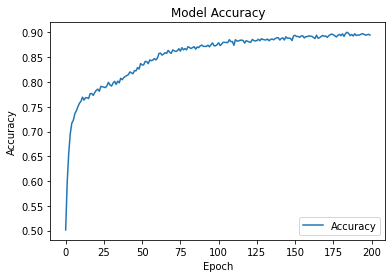

In [23]:
#Plot for accuracy across no of epochs
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'val'], loc='lower right')
plt.show()

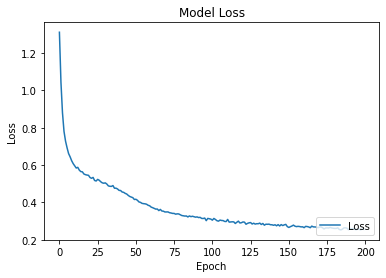

In [24]:
#Plot for Loss generated across no of epochs
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'val'], loc='lower right')
plt.show()

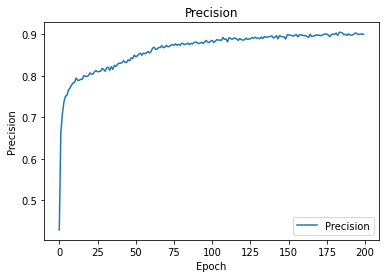

In [25]:
#Plot for precision across no of epochs
plt.plot(history.history['getPrecision'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Precision', 'val'], loc='lower right')
plt.show()

In [0]:
#Plot for F1 score across no of epochs
plt.plot(history.history['getf1Score'])
plt.title('F1 score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['F1 Score', 'val'], loc='lower right')
plt.show()

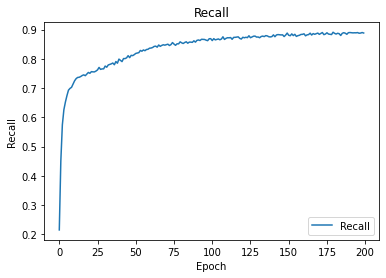

In [0]:
#Plot for recall across no of epochs
plt.plot(history.history['getRecall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Recall', 'val'], loc='lower right')
plt.show()

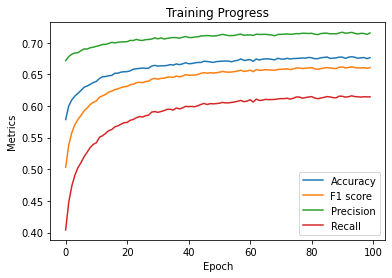

In [107]:
#Plotting the training progress over number of epochs
plt.plot(history.history['acc'])
plt.plot(history.history['getf1Score'])
plt.plot(history.history['getPrecision'])
plt.plot(history.history['getRecall'])
plt.title('Training Progress')
plt.ylabel('Metrics')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'F1 score', 'Precision', 'Recall'], loc='lower right')
plt.show()

In [0]:
# Saving the training model
import torch
torch.save(model, 'Assign2.pt')

In [0]:
import torch
model = torch.load('Assign2.pt')
model.eval()

ValueError: ignored

In [108]:
# Serialize model to JSON
# Saving the model
from keras.models import model_from_json
json = model.to_json()
with open("1102484_1dconv_class.json", "w") as json_file:
    json_file.write(json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [109]:
json = open('1102484_1dconv_class.json', 'r')
jsonModel = json.read()
json.close()
savedModel = model_from_json(jsonModel)
# load weights into new model
savedModel.load_weights("model.h5")
print("Loaded model from disk") 


Loaded model from disk


In [110]:
# evaluate loaded model on test data
savedModel.model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',getf1Score,getPrecision, getRecall])
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [111]:
#Printing all the evaluation metrics
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('F1 score:', f1_score)
print('Precision:', precision)
print('Recall:', recall)

Test loss: 0.965034156422821
Test accuracy: 0.631359733435858
F1 score: 0.6168517681594854
Precision: 0.6587365218609084
Recall: 0.5811226451364859
